In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import scipy as sp
import pickle 
import random
import math 
from scipy import optimize as opt
from astropy.io import fits
from astropy.table import Table, Column, vstack, hstack
import pyarrow.parquet as pq
from astropy import units as u
from astropy.coordinates import SkyCoord, Distance
from astropy.coordinates import BarycentricMeanEcliptic

from astropy.io import fits
from astropy.table import QTable
from astropy.time import Time
import healpy as hp

# Deep Field Selection

__Goal__: color-magnitude cut that goes deeper selecting sources to be photometered, utilizing deep field sentivitiy. While going deeper, we need to keep confusion under control.

__Considerations__: 
* Confusion from photometered sources
* Confusion from sub-threshold sources
* Varying sensitivity with ecliptic latitude

__Simulations__:
* Isolated Tractor photometry + Photoz on a small sample of sources placed at varying ecliptic latitude / NEP
    * Generate color-mag plot with redshift errors
    * Identify some 'contour' cuts 
* Blended Tractor photometry + Photoz: on everything (primary source and nearby bright sources to photometer, plus sub-threshold sources), multiple runs with varying color-magnitude selection cuts from the first simulation.
    * COSMOS sources placed at SPHEREx RC RA, DEC in a small region near NEP; 
    * or, Jordan's simulated catalog and SEDs.
    





##   Deep field coordinates using jean's data

In [80]:
## reduce nmc to 50 
file = "../../../../source_selection/data/obs_per_ecliptic_lat_R3.fits"
# file = "../../../../source_selection/data/spherex_hit_map_84.0_90.0_nside512.fits"

with fits.open(file) as hdul:
    print(len(hdul))
    print(hdul[1].header)
    data = hdul[1].data

with fits.open('../../../../SPHEREx_2023/COSMOS2020_FARMER_R1_v2.1_p3_in_Richard_sim_2023Dec4.fits') as fits_data:
    cosmos = Table(fits_data[1].data)
    
## The cosmology reference catalog
cosmos_rc = "../../../../source_selection/COSMOS2020_SPHEXrefcat_v0.6_166k_withredshift_gemma_JAN2025.csv"
cosmos_rc = Table.read(cosmos_rc)


2
XTENSION= 'BINTABLE'           / binary table extension                         BITPIX  =                    8 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                   24 / length of dimension 1                          NAXIS2  =                  167 / length of dimension 2                          PCOUNT  =                    0 / number of group parameters                     GCOUNT  =                    1 / number of groups                               TFIELDS =                    3 / number of table fields                         TTYPE1  = 'ecliptic_lat'                                                        TFORM1  = 'D       '                                                            TTYPE2  = 'observations'                                                        TFORM2  = 'D       '                                                            TTYPE3  = 'std     '                  

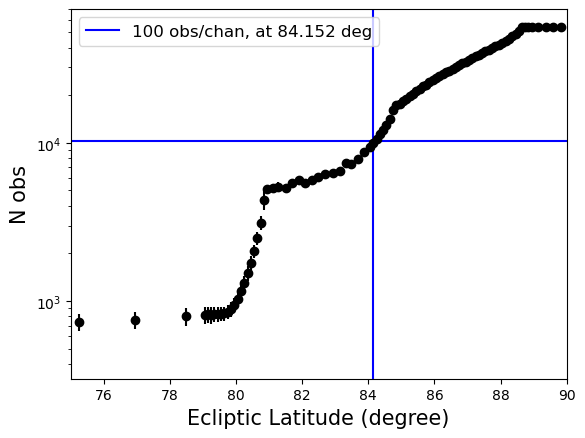

In [76]:
plt.errorbar(data['ecliptic_lat'], data['observations'], yerr=data['std'], fmt='o', color='black')
plt.yscale("log")
plt.xlim(75, 90)
plt.xlabel("Ecliptic Latitude (degree)", fontsize=15)
plt.ylabel("N obs", fontsize=15)

# find E.lat where 100 obs / chan
idx = np.where(abs(data['observations']-(102*100)) == (abs(data['observations']-(102*100))).min())[0][0]

plt.axhline(100*102, color='blue')
plt.axvline(data['ecliptic_lat'][idx], label=f"100 obs/chan, at {data['ecliptic_lat'][idx]:.3f} deg", color='blue')
plt.legend(fontsize=12)

RA, DEC for the 100 obs / channel is  284.4404263395492 65.88209300691376
number of sources in the cosmology flag, in the selected region =  1031


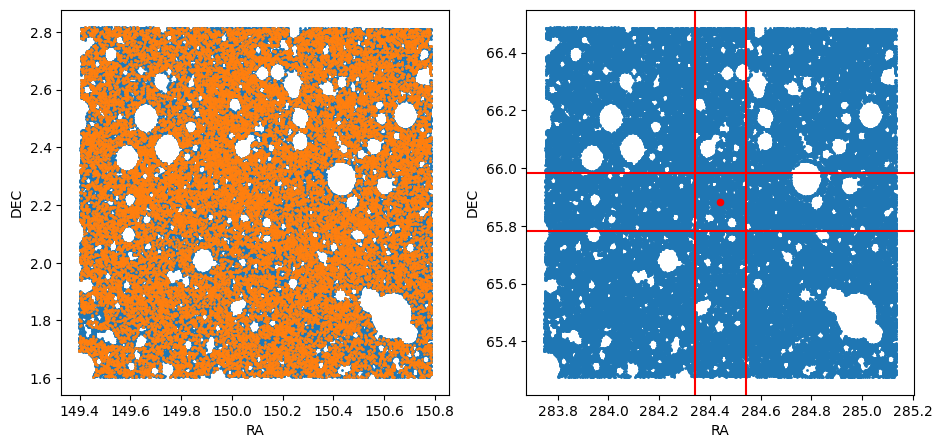

In [112]:
## find coordinates to do photometry at, convert to RA, DEC
elat = data['ecliptic_lat'][idx]
elon = 0 * u.deg # deg
crd = SkyCoord(elon, elat * u.deg, frame=BarycentricMeanEcliptic)  # NEP at (lon=0, lat=90)
ra0 = crd.transform_to('icrs').ra.deg
dec0 = crd.transform_to('icrs').dec.deg
print('RA, DEC for the 100 obs / channel is ', ra0, dec0)

## transform COSMOS field center to deep field
ra_c = (cosmos['ALPHA_J2000'].max() - cosmos['ALPHA_J2000'].min()) / 2 + cosmos['ALPHA_J2000'].min()
dec_c = (cosmos['DELTA_J2000'].max() - cosmos['DELTA_J2000'].min()) / 2 + cosmos['DELTA_J2000'].min()
if "ra_deep" not in cosmos.colnames:
    cosmos.add_column((cosmos['ALPHA_J2000'].copy() + (ra0 - ra_c)), name="ra_deep")
    cosmos.add_column((cosmos['DELTA_J2000'].copy() + (dec0 - dec_c)), name="dec_deep")

plt.figure(figsize=(11,5))
plt.subplot(1,2,1)
plt.scatter(cosmos['ALPHA_J2000'], cosmos['DELTA_J2000'], s=1)
flag_cosmology = cosmos_rc['COSMOLOGY']==1
plt.scatter(cosmos['ALPHA_J2000'][flag_cosmology], cosmos['DELTA_J2000'][flag_cosmology], s=1)
plt.xlabel("RA")
plt.ylabel("DEC")

plt.subplot(1,2,2)
plt.scatter(cosmos['ra_deep'], cosmos['dec_deep'], s=1)
plt.scatter(ra0, dec0, color='red', s=20)

## select a subsample surrounding the chosen coordinate pair
ra_min = ra0 - 0.1
ra_max = ra0 + 0.1
dec_min = dec0 - 0.1
dec_max = dec0 + 0.1
plt.axvline(ra_min, color='red')
plt.axvline(ra_max, color='red')
plt.axhline(dec_min, color='red')
plt.axhline(dec_max, color='red')

## count number of cosmology sources in the patch
flag_sub = (cosmos['ra_deep']>=ra_min) & \
           (cosmos['ra_deep']<=ra_max) & \
           (cosmos['dec_deep']>=dec_min) & \
           (cosmos['dec_deep']<=dec_max)
N_srcs_to_phot = len(np.where(flag_sub & flag_cosmology)[0])
print("number of sources in the cosmology flag, in the selected region = ", N_srcs_to_phot)

plt.xlabel("RA")
plt.ylabel("DEC")
plt.show()

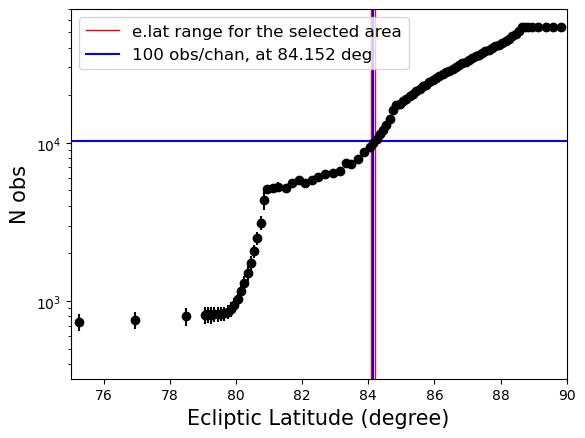

In [113]:
## convert the chosen region to ecliptic coordinates and compute the N obs variation
crds_chosen = SkyCoord(ra = cosmos['ra_deep'][flag_cosmology & flag_sub] * u.deg,
                       dec = cosmos['dec_deep'][flag_cosmology & flag_sub] * u.deg, 
                       frame='icrs')
crds_chosen_eclp = crds_chosen.transform_to(BarycentricMeanEcliptic)
plt.errorbar(data['ecliptic_lat'], data['observations'], yerr=data['std'], fmt='o', color='black')
plt.axvline(crds_chosen_eclp.lat.deg.max(), color='red', lw=1)
plt.axvline(crds_chosen_eclp.lat.deg.min(), color='red', lw=1, label='e.lat range for the selected area')

plt.yscale("log")
plt.xlim(75, 90)
plt.xlabel("Ecliptic Latitude (degree)", fontsize=15)
plt.ylabel("N obs", fontsize=15)
plt.axhline(100*102, color='blue')
plt.axvline(data['ecliptic_lat'][idx], label=f"100 obs/chan, at {data['ecliptic_lat'][idx]:.3f} deg", color='blue')
plt.legend(fontsize=12)

In [ ]:
cosmos['col1']

In [119]:

with fits.open("../../../hires_sed_COSMOS_0_60000_new010925_nolines_gemma.fits") as catalog:
    print(len(catalog))
    ii= 30000
    print(catalog[ii].header)
    spectrum = Table(
                    [
                        catalog[ii].data['wavelength'],
                        catalog[ii].data['sed_flux_mJy'],
                    ],
                    names=('lambda', 'FLUX'),
                )

60001
XTENSION= 'BINTABLE'           / binary table extension                         BITPIX  =                    8 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                   16 / length of dimension 1                          NAXIS2  =                 1105 / length of dimension 2                          PCOUNT  =                    0 / number of group parameters                     GCOUNT  =                    1 / number of groups                               TFIELDS =                    2 / number of table fields                         TTYPE1  = 'wavelength'                                                          TFORM1  = 'D       '                                                            TTYPE2  = 'sed_flux_mJy'                                                        TFORM2  = 'D       '                                                            EXTNAME = '180634  '              

# Redshift Validation of Confusion


## QuickCatalog run on isolated COSMOS 32k

In [4]:

import sys
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, hstack
from astropy.io import fits
from astropy.coordinates import SkyCoord, Distance
from astropy.coordinates import BarycentricMeanEcliptic
import itertools
from concurrent.futures import ProcessPoolExecutor
import multiprocessing as mp
import time 
import argparse
import os

import SPHEREx_ObsSimulator as SPobs
from SPHEREx_Simulator_Tools import data_filename
import SPHEREx_InstrumentSimulator as SPinst
from spherex_parameters import load_spherex_parameters
import SPHEREx_SkySimulator as SPsky
from SPHEREx_SkySimulator import QuickCatalog
from SPHEREx_SkySimulator import Catalog_to_Simulate

survey_plan_file = data_filename('spherex_survey_plan_R2.fits')
SPHEREx_Pointings = SPobs.Pointings(input_file=survey_plan_file, 
                                        Gaussian_jitter = 0.0, roll_angle='psi2')
# Load instrument and project parameters as a dictionary
spherex_parameters = load_spherex_parameters()
Scene = SPsky.Scene(SPHEREx_Pointings,
                        zodi_model=SPsky.zodicalc.ModifiedKelsallModelWithHPFT())

Channels = Table.read(data_filename('Channel_Definition_03022021.fits'))
# Instrument (no noise - get rid of noise_model and dark_current_model --> dark current, read noise, photon noise, zodi = 0)
trim = 32
ds = 4
SPHEREx_Instrument = SPinst.Instrument(
    instrument_data=spherex_parameters,
    psf=data_filename("psf/simulated_PSF_database_centered_v3_og.fits"),
    psf_downsample_by_array={1: ds, 2: ds, 3: ds, 4: ds, 5: ds, 6: ds},
    psf_trim_by_array={1: trim, 2: trim, 3: trim, 4: trim, 5: trim, 6: trim},
    noise_model=SPinst.white_noise,
    dark_current_model=SPinst.poisson_dark_current,
    lvf_model=SPinst.Tabular_Bandpass()
)

##--------- functions -------------
# function finding the new, corrected fits file
def find_sed_fits_file_corrected(index, tractorID):
    if index < 60000:
        #print("0 - 60000")
        DIR = "/Users/gemmahuai/Desktop/CalTech/SPHEREx/COSMOS_ALL_HIRES_SEDS_010925/0_60000/"
    elif index < 120000:
        #print("60000 - 120000")
        DIR = "/Users/gemmahuai/Desktop/CalTech/SPHEREx/COSMOS_ALL_HIRES_SEDS_010925/60000_120000/"
    else:
        #print("120000 - ")
        DIR = "/Users/gemmahuai/Desktop/CalTech/SPHEREx/COSMOS_ALL_HIRES_SEDS_010925/120000_166041/"
    
    filename = DIR + f"cosmos2020_hiresSED_FarmerID_{tractorID:07d}_corrected.fits"
    return filename


## Load COSMOS reference catalogs
COSMOS_tab = Table.read('/Users/gemmahuai/Desktop/CalTech/SPHEREx/SPHEREx_2023/COSMOS2020_FARMER_R1_v2.1_p3_in_Richard_sim_2023Dec4.fits', format='fits')
# CUT_xmatch = np.loadtxt('../source_selection/final_cut_boolarray.txt', dtype=bool)
# COSMOS_tab = COSMOS_tab[CUT_xmatch]

# # idx_refcat = np.loadtxt("./newrefcat_bool_COSMOSzch1.txt", dtype=bool)
# idx_refcat = np.loadtxt("../source_selection/final_colormag_cut_boolarray_nov2024.txt", dtype=bool)
idx_refcat = np.loadtxt("/Users/gemmahuai/Desktop/CalTech/SPHEREx/source_selection/cosmos166k_posmatch_boolarray.txt", dtype=bool)


## Move COSMOS to the deep field
file = "/Users/gemmahuai/Desktop/CalTech/SPHEREx/source_selection/data/obs_per_ecliptic_lat_R3.fits"
with fits.open(file) as hdul:
    data = hdul[1].data

# find ecliptic latitude where Nobs ~ 100 / channel --> 102*100 obs in total
idx = np.where(abs(data['observations']-(102*100)) == (abs(data['observations']-(102*100))).min())[0][0]
elat = data['ecliptic_lat'][idx]
elon = 0 * u.deg # deg # longitude doesn't matter, assuming symmetric about NEP.
crd = SkyCoord(elon, elat * u.deg, frame=BarycentricMeanEcliptic)  # NEP at (lon=0, lat=90)
ra0 = crd.transform_to('icrs').ra.deg
dec0 = crd.transform_to('icrs').dec.deg
print('RA, DEC for the 100 obs / channel is ', ra0, dec0)

# move COSMOS centered around this calculated coordinate pair.
ra_c = (COSMOS_tab['ALPHA_J2000'].max() - COSMOS_tab['ALPHA_J2000'].min()) / 2 + COSMOS_tab['ALPHA_J2000'].min()
dec_c = (COSMOS_tab['DELTA_J2000'].max() - COSMOS_tab['DELTA_J2000'].min()) / 2 + COSMOS_tab['DELTA_J2000'].min()
if "ra_deep" not in COSMOS_tab.colnames:
    COSMOS_tab.add_column((COSMOS_tab['ALPHA_J2000'].copy() + (ra0 - ra_c)), name="ra_deep")
    COSMOS_tab.add_column((COSMOS_tab['DELTA_J2000'].copy() + (dec0 - dec_c)), name="dec_deep")

## select a subsample surrounding the chosen coordinate pair ~ 0.2 * 0.2 deg^2 area --> 1k refcat sources
ra_min = ra0 - 0.1
ra_max = ra0 + 0.1
dec_min = dec0 - 0.1
dec_max = dec0 + 0.1
## count number of cosmology sources in the patch
flag_sub = (COSMOS_tab['ra_deep']>=ra_min) & \
           (COSMOS_tab['ra_deep']<=ra_max) & \
           (COSMOS_tab['dec_deep']>=dec_min) & \
           (COSMOS_tab['dec_deep']<=dec_max)
print("Number of refcat sources in the selected area = ", len(COSMOS_tab[idx_refcat & flag_sub]))


## Isolated photometry
i = 3
tID_central = COSMOS_tab['Tractor_ID'][idx_refcat & flag_sub][i]
print("tID = ", tID_central)
ra = COSMOS_tab['ra_deep'][idx_refcat & flag_sub][i]
dec = COSMOS_tab['dec_deep'][idx_refcat & flag_sub][i]
# ra = ra_c
# dec = dec_c

# start timing
time_start = time.time()
QC = QuickCatalog(SPHEREx_Pointings, SPHEREx_Instrument, Scene, Use_Tractor=False, spectral_channel_table=Channels,\
                  #do_not_fit=source_name,\
                  subpixel_offset_x=0, subpixel_offset_y=0)
Sources_to_Simulate_close = Catalog_to_Simulate()
# The central source to fit (refcat)
central_sed_fn = find_sed_fits_file_corrected(COSMOS_tab['col1'][idx_refcat & flag_sub][i],
                                              COSMOS_tab['Tractor_ID'][idx_refcat & flag_sub][i])
print("filename = ", central_sed_fn)
Sources_to_Simulate_close.load_single(name=f"Central tID {int(tID_central)}", 
                                      ra=ra*u.deg, 
                                      dec=dec*u.deg, 
                                      inputpath=central_sed_fn)
# run QuickCatalog
SPHEREx_Catalog, Truth_Catalog= QC(Sources_to_Simulate_close)

# collate output secondary photometry tables
file_inter = '/Users/gemmahuai/Desktop/CalTech/SPHEREx/Redshift/deep_field/data/secondary_phot_id{}.parq'.format(i) # intermediate parquet file saving primary photometry
            # save secondary photometry
this = SPHEREx_Catalog['SOURCE_ID']==f"Central tID {int(tID_central)}"
SPsky.save_level3_secondary(SPHEREx_Catalog[this], 
                            Channels, 
                            SPHEREx_Instrument, 
                            file_inter, 
                            pointing_table=SPHEREx_Pointings.pointing_table, 
                            fluxerr_from_weights=True)
secondary_tbl = Table.read(file_inter, format="parquet")
time_end = time.time()

print("\nTime elapsed = ", time_end - time_start)





RA, DEC for the 100 obs / channel is  284.4404263395492 65.88209300691376
Number of refcat sources in the selected area =  1031
tID =  15214
filename =  /Users/gemmahuai/Desktop/CalTech/SPHEREx/COSMOS_ALL_HIRES_SEDS_010925/0_60000/cosmos2020_hiresSED_FarmerID_0015214_corrected.fits

Time elapsed =  76.0470826625824


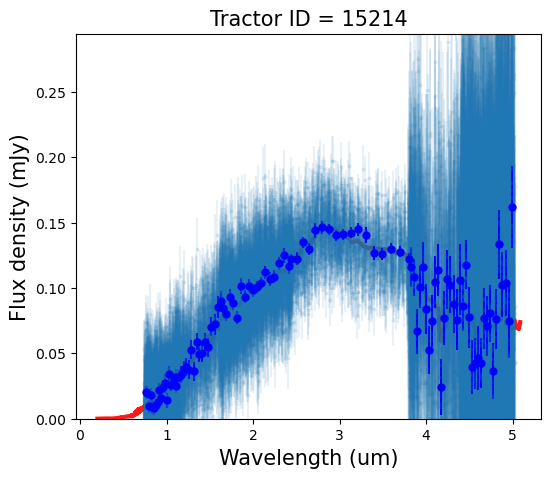

In [5]:
hires_sed = Table.read(central_sed_fn, format='fits')

fig = plt.figure(figsize=(6,5))
plt.plot(hires_sed['lambda'], hires_sed['FLUX'], color='red', lw=3, alpha=0.9, label='Input SED')
plt.errorbar(SPHEREx_Catalog[this]['WAVELENGTH'], SPHEREx_Catalog[this]['FLUX'], SPHEREx_Catalog[this]['FLUX_ERR'], 
             fmt='o', ms=2, alpha=0.1, label='primary')
plt.errorbar(secondary_tbl[0]['lambda'], secondary_tbl[0]['flux_allsky']/1000, yerr=secondary_tbl[0]['flux_err_allsky']/1000,
             fmt='o', ms=5, color='blue', label='secondary')
plt.ylim(0, hires_sed['FLUX'].max()*2)
plt.title(f"Tractor ID = {tID_central}", fontsize=15)
plt.xlabel("Wavelength (um)", fontsize=15)
plt.ylabel("Flux density (mJy)", fontsize=15)
plt.show()


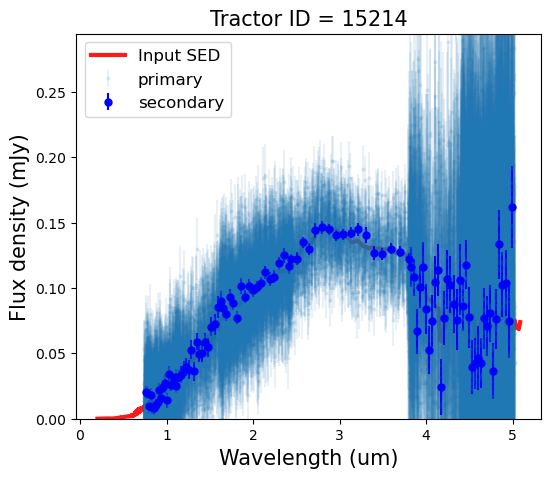

In [6]:

hires_sed = Table.read(central_sed_fn, format='fits')

fig = plt.figure(figsize=(6,5))
plt.plot(hires_sed['lambda'], hires_sed['FLUX'], color='red', lw=3, alpha=0.9, label='Input SED')
plt.errorbar(SPHEREx_Catalog[this]['WAVELENGTH'], SPHEREx_Catalog[this]['FLUX'], SPHEREx_Catalog[this]['FLUX_ERR'], 
             fmt='o', ms=2, alpha=0.1, label='primary')
plt.errorbar(secondary_tbl[0]['lambda'], secondary_tbl[0]['flux_allsky']/1000, yerr=secondary_tbl[0]['flux_err_allsky']/1000,
             fmt='o', ms=5, color='blue', label='secondary')
plt.ylim(0, hires_sed['FLUX'].max()*2)
plt.title(f"Tractor ID = {tID_central}", fontsize=15)
plt.xlabel("Wavelength (um)", fontsize=15)
plt.ylabel("Flux density (mJy)", fontsize=15)
plt.legend(fontsize=12)
plt.show()


## Background Subtraction Bias in Tractor

In [ ]:
ra = ra_c
dec = dec_c

size = 6.2 * 10 / 3600 # 10 pixel extent in deg
ra_l = ra - size / 2
ra_h = ra + size / 2
dec_l = dec - size /2 
dec_h = dec + size / 2
want = (COSMOS_tab['ra']<=ra_h) &\
    (COSMOS_tab['ra']>=ra_l) &\
    (COSMOS_tab['dec']<=dec_h) &\
    (COSMOS_tab['dec']>=dec_l)
# select all background sources within this area, do src_sub
want_id = np.where(want)[0]

# initialize arrays to hold true sub-threshold sources
bg_id = np.array([], dtype=int)
bg_tractor_id = np.array([], dtype=int)
for id in want_id:
    if idx_refcat[id] == False:
        bg_id = np.append(bg_id, id) # pre-id (index) among 166k catalog
        bg_tractor_id = np.append(bg_tractor_id, COSMOS_tab['Tractor_ID'][id])
print("   Number of nearby sub-threshold sources = ", len(bg_tractor_id)) 

# create a list of background source name
source_name = []
for name in bg_tractor_id:
    source_name.append("COSMOS2020_" + "{}".format(name).zfill(7))

# initiate QC with Tractor
time_start = time.time()
QC = QuickCatalog(SPHEREx_Pointings, SPHEREx_Instrument, Scene, \
                  Use_Tractor=True, spectral_channel_table=Channels,\
                  do_not_fit=source_name,\
                  return_fit=f"Central tID {int(tID_central)}",\
                  subpixel_offset_x=0, subpixel_offset_y=0)
Sources_to_Simulate_confusion = Catalog_to_Simulate()

Sources_to_Simulate_confusion.load_single(name=f"Central tID {int(tID_central)}", 
                                        ra=ra*u.deg, 
                                        dec=dec*u.deg, 
                                        inputpath=central_sed_fn)

## add in nearby background sources sed
for n in range(len(bg_tractor_id)):

    ra_sub = COSMOS_tab['ra'][bg_id[n]]
    dec_sub = COSMOS_tab['dec'][bg_id[n]]
    # print("\n")
    # print(bg_tractor_id[n], idx_refcat[bg_id[n]], '  ra=', ra_sub, '  dec=', dec_sub)

    filename = find_sed_fits_file_corrected(index=bg_id[n],
                                            tractorID=bg_tractor_id[n])
    # print(filename)

    Sources_to_Simulate_confusion.load_single(name=source_name[n],
                                            ra=ra_sub*u.deg,
                                            dec=dec_sub*u.deg,
                                            inputpath=filename)

# run QuickCatalog, return the best fit model for the primary source
SPHEREx_Catalog_confusion, Truth_Catalog_confusion, hdulist = QC(Sources_to_Simulate_confusion, nmc=50)


   Number of nearby sub-threshold sources =  21


## QC + Tractor with sub-threshold confusion

__confusion injection__:

Could inject confusion library into controlled, isolated QC deep field photometry;

Compare with such redshift results with Tractor on with confusion QC run. 